# Exocomet free spectrum

In this workbook we want to create an "exocomet free" spectrum. Wish such a spectrum we can remove constant spectral features and thus be left with only the signatures of the exocomets.

### Load the data

In [1]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

# get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions from src
from calculations import Calc, Model, Stats

# We shorten the functions name to make it easier to call the required a functions
c   = Calc()
m   = Model()
s   = Stats()

# Importing parameters from a json file.
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# We select part A which is the red end of the spectrum (the other part being B, which is the blue end)
part     = param["BetaPictoris"]["part"]

Repository home directory: /home/pas/science/exocomets


In [2]:
# The structure here is
# DP[visit][orbit][0 = wavelength, 1 = flux, 2 = one sigma uncertainty, 3 = datetime]
DP   = c.LoadData(home+'/data/Dnsn_'+part+'.npz')

### Create a master spectrum
We do a weighted average of the spectra.

In [3]:
import numpy as np

spec        = []
spec_err    = []

for i in range(len(DP)):          # Cycle over number of visits
    for j in range(len(DP[i])):   # Cycle over number of fits files each visit
        spec.append(DP[i][j][1])
        spec_err.append(DP[i][j][2])

spec        = np.array(spec)
spec_err    = np.array(spec_err)

print("Combining",str(len(spec))," spectra")

spec        = c.ReplaceWithSmallNumber(spec)
spec_err    = c.ReplaceWithOne(spec_err)

weights     = 1./(spec_err**2)
weights     = weights/np.sum(weights)   # Technically not needed as np.average does this

spec_w_ave  = np.average(spec, axis=0, weights=weights)
errorbars_2 = np.sum((weights*spec_err)**2, axis=0)

Combining 35  spectra


### Create an exocomet free spectrum
We set a threshold at 90% which means we define a threshold were we only accept flux values in the top 10%. 

In [4]:
spec_max = np.max(spec, axis=0)
threshold = np.percentile(spec, 90, axis=0)

# Calculate the standard deviation across all spectra at for each wavelength. E.g. calculate the
# standard deviation of all spectra at f[n] where n is an array element.
spec_std = np.std(spec, axis=0)

In [5]:
# We adopt the wavlenth array from the 2014 visit (any other date would do as all the spectra are aligned)
w = DP[0][0][0]

# We select the region we are interested in
s1, s2 = c.RegionSelect(w, 1396, 1402)

# Calculate the average uncertainty for a specific wavelength region
ave_uncertainty = np.average(spec_std[s1:s2])

ave_errorbars = np.average(spec_err, axis=0)

ave_errorbars_selection = np.average(ave_errorbars[s1:s2])

print("Standard deviation derived uncetrainties:\t",ave_uncertainty)
print("Average calculated uncetrainties:\t\t",ave_errorbars_selection)
print("The uncertainties are underestimated by a factor:",round(ave_uncertainty/ave_errorbars_selection,2))

# We take a conservative approach and use the larger of the two average uncertainties.
spec_exocomet_free = threshold-ave_uncertainty

Standard deviation derived uncetrainties:	 2.415795886844948e-14
Average calculated uncetrainties:		 2.0184012068608684e-14
The uncertainties are underestimated by a factor: 1.2


In [6]:
# Setting the parameters for the plots
plotting_params = {'backend': 'wxAgg',
                   'font.family': 'serif',
                   'font.size': 22,
                   'lines.markersize' : 2,
                   'axes.labelsize': 22,
                   'legend.fontsize': 22,
                   'xtick.labelsize': 22,
                   'ytick.labelsize': 22,
                   'text.usetex': True}

plt.rcParams.update(plotting_params)

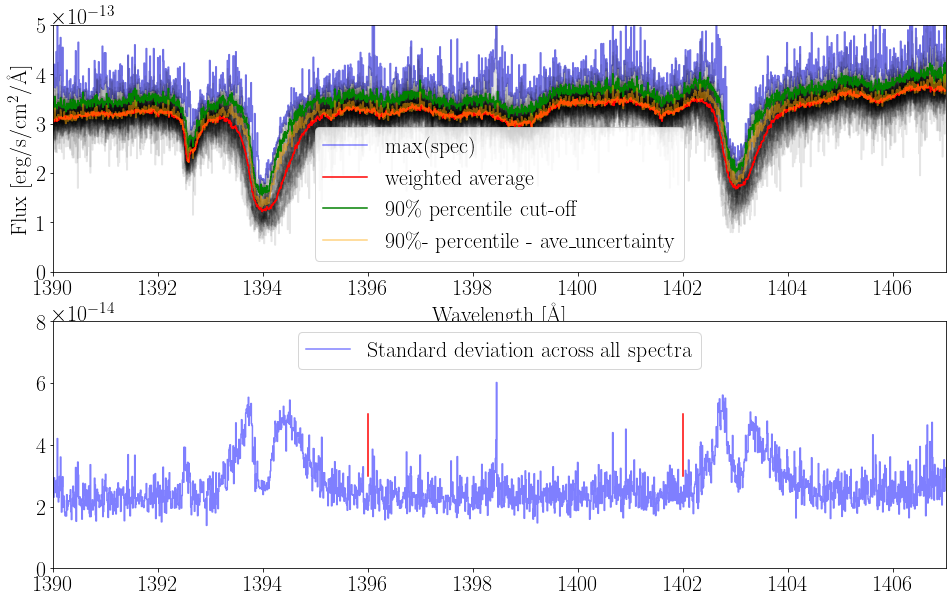

In [7]:
#%matplotlib widget
fig = plt.figure(figsize=(16.0,10.0))

ax1 = plt.subplot(211)
plt.step(DP[0][0][0],spec_max,c="blue",alpha=0.5,label="max(spec)")

for i in range(len(DP)):
    for j in range(len(DP[i])):
        plt.step(DP[i][j][0],DP[i][j][1],c="black",alpha=0.1)
plt.step(DP[0][0][0],spec_w_ave,c="red",label="weighted average")
plt.step(DP[0][0][0],threshold,c="green",label="90\% percentile cut-off")
plt.step(DP[0][0][0],spec_exocomet_free,c="orange",alpha=0.5,label="90\%- percentile - ave_uncertainty")

plt.legend(loc='lower center', numpoints=1)
plt.xlim(1390,1407)
plt.ylim(0,5e-13)

plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')

ax1 = plt.subplot(212)
plt.plot([w[s1],w[s1]],[3e-14,5e-14],color="red")
plt.plot([w[s2],w[s2]],[3e-14,5e-14],color="red")
plt.step(DP[0][0][0],spec_std,c="blue",alpha=0.5,label="Standard deviation across all spectra")
plt.xlim(1390,1407)
plt.ylim(0,0.8e-13)
plt.legend(loc='upper center', numpoints=1)

The dips in the line center show that the line is saturated.

Text(0.5, 0, 'Wavelength [\\AA]')

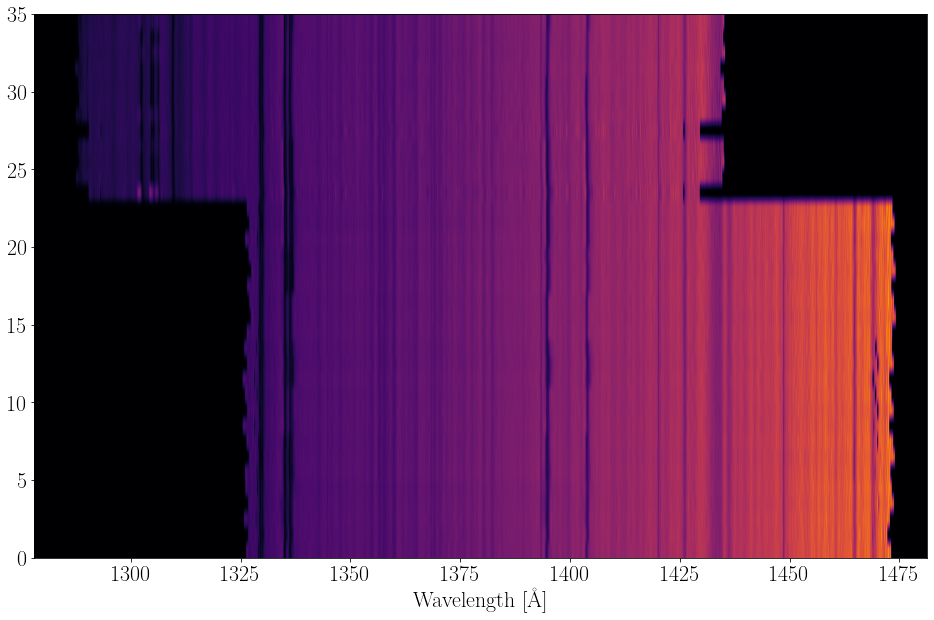

In [8]:
# We plot the entire dataset with the earlier spectra shown at the top of the plot.
spec_range   = len(w)
rows         = len(spec)

S            = spec.reshape(rows,spec_range)
cmap = plt.get_cmap('inferno')

fig = plt.figure(figsize=(16.0,10.0))
plt.imshow(S,cmap=cmap,extent=[w[0],w[-1],0,len(S)],aspect='auto')
plt.xlabel(r'Wavelength [\AA]')
#plt.xlim(1392, 1407)

### We subtract off the exocomet free spectrum

In [9]:
y_ticks = []
y_labels = []
counter = 50
spec_exocomet = []
for i in range(len(DP)):
    for j in range(len(DP[i])):
        print("█▓▒▒░░░ Visit:",i+1,"-","orbit:",str(j+1)+"/"+str(len(DP[i])),"░░░▒▒▓█")
        spec_exocomet.append(DP[i][j][1]-spec_exocomet_free)
        
        if j == len(DP[i])-1:
            counter = counter - len(DP[i])-1.0
            y_labels.append(DP[i][j][3].strftime("%d %b %Y"))
            y_ticks.append(counter)
            spec_exocomet.append(np.ones(spec_range)*-1)
            print("")

spec_exocomet = np.array(spec_exocomet)

█▓▒▒░░░ Visit: 1 - orbit: 1/1 ░░░▒▒▓█

█▓▒▒░░░ Visit: 2 - orbit: 1/3 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 2/3 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 3/3 ░░░▒▒▓█

█▓▒▒░░░ Visit: 3 - orbit: 1/4 ░░░▒▒▓█
█▓▒▒░░░ Visit: 3 - orbit: 2/4 ░░░▒▒▓█
█▓▒▒░░░ Visit: 3 - orbit: 3/4 ░░░▒▒▓█
█▓▒▒░░░ Visit: 3 - orbit: 4/4 ░░░▒▒▓█

█▓▒▒░░░ Visit: 4 - orbit: 1/4 ░░░▒▒▓█
█▓▒▒░░░ Visit: 4 - orbit: 2/4 ░░░▒▒▓█
█▓▒▒░░░ Visit: 4 - orbit: 3/4 ░░░▒▒▓█
█▓▒▒░░░ Visit: 4 - orbit: 4/4 ░░░▒▒▓█

█▓▒▒░░░ Visit: 5 - orbit: 1/3 ░░░▒▒▓█
█▓▒▒░░░ Visit: 5 - orbit: 2/3 ░░░▒▒▓█
█▓▒▒░░░ Visit: 5 - orbit: 3/3 ░░░▒▒▓█

█▓▒▒░░░ Visit: 6 - orbit: 1/3 ░░░▒▒▓█
█▓▒▒░░░ Visit: 6 - orbit: 2/3 ░░░▒▒▓█
█▓▒▒░░░ Visit: 6 - orbit: 3/3 ░░░▒▒▓█

█▓▒▒░░░ Visit: 7 - orbit: 1/3 ░░░▒▒▓█
█▓▒▒░░░ Visit: 7 - orbit: 2/3 ░░░▒▒▓█
█▓▒▒░░░ Visit: 7 - orbit: 3/3 ░░░▒▒▓█

█▓▒▒░░░ Visit: 8 - orbit: 1/3 ░░░▒▒▓█
█▓▒▒░░░ Visit: 8 - orbit: 2/3 ░░░▒▒▓█
█▓▒▒░░░ Visit: 8 - orbit: 3/3 ░░░▒▒▓█

█▓▒▒░░░ Visit: 9 - orbit: 1/3 ░░░▒▒▓█
█▓▒▒░░░ Visit: 9 - orbit: 2/3 ░░░▒▒▓█
█▓▒▒

### We produce the exocomet plot (all constant spectral lines have been subtracted out)

Text(0.5, 0, 'RV [km/s]')

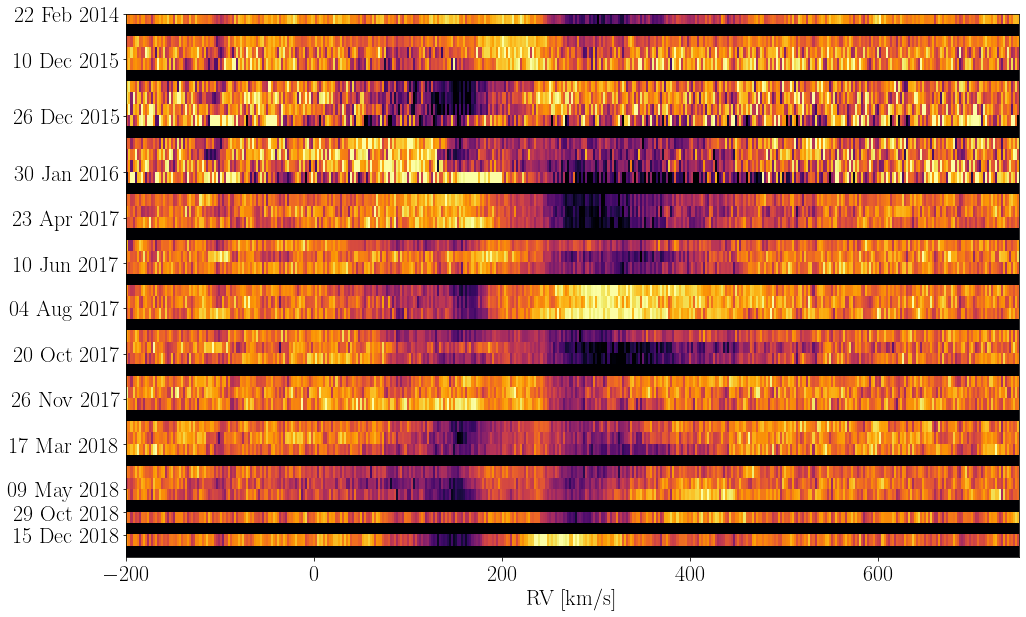

In [10]:
rows         = len(spec_exocomet)
EXO          = spec_exocomet.reshape(rows,spec_range)

rv = c.Wave2RV(w,1393.7550,20.5)

fig = plt.figure(figsize=(16.0,10.0))
plt.imshow(EXO,cmap=cmap,extent=[rv[0],rv[-1],0,len(EXO)],interpolation='none',vmin=-1.2e-13,vmax=5e-14,aspect='auto')
plt.xlim(-200, 750)
plt.gca().set_yticks(y_ticks) 
plt.gca().set_yticklabels(y_labels)
plt.xlabel(r'RV [km/s]')